# CS:4440 - Web Mining 
# Homework 1

### Data Description

The source file respresents a network of Reddit users and their connections. Each row (source user) is deliminated by '|' and their column (linked users) is deliminated by ','.

In [5]:
# Imports
import csv
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections

### Dataset import and description

Reading in the dataset with columns 'source user' and 'linked users'.

In [6]:
# Read dataset
data = pd.read_csv('networkDataset_v2.psv',skiprows=1, sep = "|", index_col=False, 
                 names=['source user', 'linked users'])
data

,source user,linked users
0,frankEfurter,"IReadItOnReddit43,Mmiklase,erdbeerheld,owljay,..."
1,simplythrowmeaway,"larsskynyrd79,deathangel1217,linkenski,ValarM0..."
2,gmiz0,"berrythecat,alex23b,bluek00laid,Chaos_Therum,3..."
3,Frogtown_,"brokenpixel,TheCreepyDude,bluek00laid,gmiz0"
4,tinderhackflex,Liru
...,...,...
25297,optsyn,imro
25298,DJ_Skully,imro
25299,Zelda___Fitzgerald,imro
25300,Skinny128,imro


In [7]:
# Dimensions
print("Size:", data.size)
print("Shape:", data.shape)
print("Dimensions:", data.ndim)

Size: 50604
Shape: (25302, 2)
Dimensions: 2


### Dealing with multiple edges

Since each source user can have multiple linked users, the easiest way to make the data compatible with a graph library is to add separate the linked users into their own rows with the duplicated source user. 

In [8]:
# https://stackoverflow.com/questions/52804653/python-write-new-row-based-on-comma-separated-values-in-table-column
# Reindex and repeat cols on len of split and reset index
df1 = data.reindex(data.index.repeat(data['linked users'].fillna("").str.split(',').apply(len)))
df1 = df1.drop(['linked users'],1)

# Splitting both cols
s = data['linked users'].str.split(',', expand=True).stack().reset_index(level=1,drop=True)

# Now grouping the series and df using cumcount.
df1 = df1.set_index(df1.groupby(df1.index).cumcount(), append=True)
s = s.to_frame('linked users').set_index(s.groupby(s.index).cumcount(), append=True)

# Joining the all of them together and reset index.
df1 = df1.join(s, how='outer').reset_index(level=[0,1],drop=True)

df1

,source user,linked users
0,frankEfurter,IReadItOnReddit43
1,frankEfurter,Mmiklase
2,frankEfurter,erdbeerheld
3,frankEfurter,owljay
4,frankEfurter,Wooz122
...,...,...
56794,optsyn,imro
56795,DJ_Skully,imro
56796,Zelda___Fitzgerald,imro
56797,Skinny128,imro


### Using Networkx library to create a graph

Clean up data to have nodes and edges that can be used by the `networkx` library. Then, display the graph so that the node color varies with Degree and node size with Betweenness Centrality. 

[Source](https://www.datacamp.com/community/tutorials/social-network-analysis-python) for Graph Code.

In [9]:
# Using networkx to create a Graph
G = nx.Graph()

In [10]:
# Add nodes
nodes = data['source user']
G.add_nodes_from(nodes)

In [11]:
# Add edges
for i, row in df1.iterrows():
    G.add_edge(row['source user'], row['linked users'])

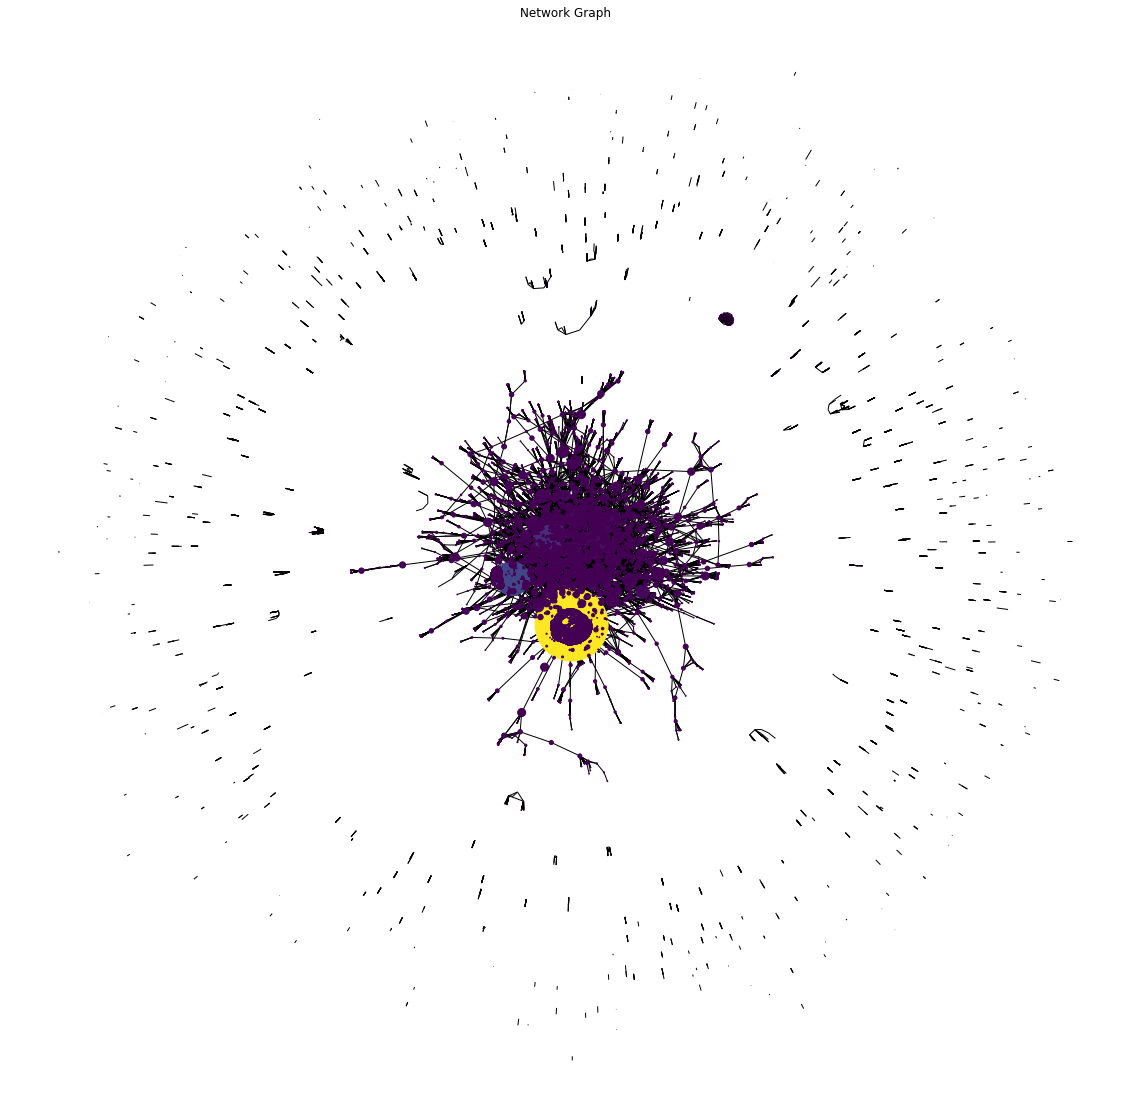

In [34]:
# Draw network 
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
plt.title('Network Graph')
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')
plt.show()

### Graph Analysis

In this section, there is an analysis of key features of the graph, which include:

- Basic Information
- Average Degree of Connectivity 
- Clustering Coefficient
- Degree distribution

In [12]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25304
Number of edges: 28611
Average degree:   2.2614


<BarContainer object of 101 artists>

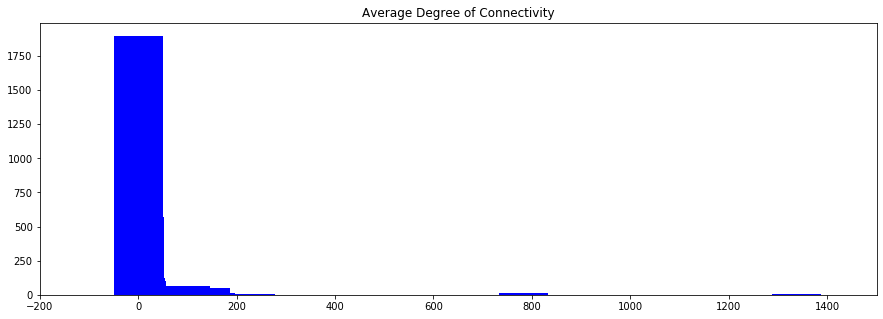

In [13]:
# Average Degree of Connectivity 
avg_degree = nx.average_degree_connectivity(G)
plt.figure(figsize=(15,5))
plt.title('Average Degree of Connectivity')
plt.xlim([-200, 1500])
plt.bar(list(avg_degree.keys()), list(avg_degree.values()), width = 100,color='b')

In [14]:
# Clustering Coefficient
avg_clustering = nx.average_clustering(G)
avg_clustering

0.08642844648903887

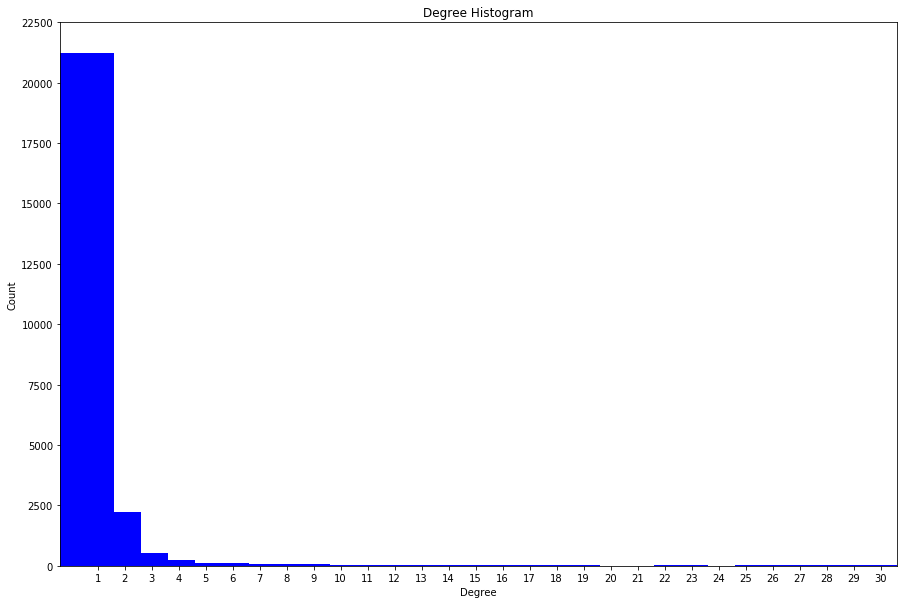

In [15]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(15,10))
plt.bar(deg, cnt, width=2, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.xlim([0, 31])
plt.ylim([0, 22500])

plt.show()

### Power Law

In [16]:
import powerlaw

In [23]:
# Figuring out the power law coefficient
degrees = {}
for node in G.nodes():
    key = len(list(G.neighbors(node)))
    degrees[key] = degrees.get(key, 0) + 1

max_degree = max(degrees.keys(), key=int)
num_nodes = []
for i in range(1, max_degree + 1):
    num_nodes.append(degrees.get(i, 0))

fit = powerlaw.Fit(num_nodes) 
print(fit.power_law.alpha + 1) #Base value of 1 for each node

2.6565993734591977


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


### Small World Phenomenon

In [24]:
from networkx.algorithms import smallworld as sm

In [35]:
sw = sm.sigma(G)

KeyError: None

In [ ]:
sw